In [106]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf # linear modeling
import xgboost as xgb
import statsmodels.formula.api as smf # linear modeling
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn import preprocessing

## Preparing the Data

### Checking for Missing Values

In [38]:
math_class = pd.read_csv('./data/student-mat.csv')
portuguese_class = pd.read_csv('./data/student-por.csv')

pd.isnull(math_class).any()

school        False
sex           False
age           False
address       False
famsize       False
Pstatus       False
Medu          False
Fedu          False
Mjob          False
Fjob          False
reason        False
guardian      False
traveltime    False
studytime     False
failures      False
schoolsup     False
famsup        False
paid          False
activities    False
nursery       False
higher        False
internet      False
romantic      False
famrel        False
freetime      False
goout         False
Dalc          False
Walc          False
health        False
absences      False
G1            False
G2            False
G3            False
dtype: bool

In [39]:
pd.isnull(portuguese_class).any()

school        False
sex           False
age           False
address       False
famsize       False
Pstatus       False
Medu          False
Fedu          False
Mjob          False
Fjob          False
reason        False
guardian      False
traveltime    False
studytime     False
failures      False
schoolsup     False
famsup        False
paid          False
activities    False
nursery       False
higher        False
internet      False
romantic      False
famrel        False
freetime      False
goout         False
Dalc          False
Walc          False
health        False
absences      False
G1            False
G2            False
G3            False
dtype: bool

At the moment, it does not look like we have any values in the data that are null/missing. This makes us think that the data set has another way of representing that data that is missing (than leaving it blank), which will be investigated further in exploratory data analysis.

### Combining the Data Sets
Since both data sets include data from students in both schools and both schools are in Portugal, we believe it is appropriate to combine the two data sets.

In [40]:
math_class['class'] = 'math'
portuguese_class['class'] = 'portuguese'

combined_data = pd.concat([math_class, portuguese_class])

# Changing categorical variables from string to categorical
combined_data.loc[:, combined_data.dtypes == object] = combined_data.loc[:, combined_data.dtypes == object].astype('category')

### Adding New Variables

Having drinking split up into workday and weekend drinking does not make much sense since we are trying to predict drinking level overall. As such, we will average these two columns into an overall_drinking feature. Furthermore, it has been proven that [poorer people are more negatively affected by alcohol](https://www.thelancet.com/journals/lanpub/article/PIIS2468-2667(17)30078-6/fulltext?elsca1=tlxpr), both in risk for dangerous drinking behaviors and effects of excessive drinking. While not a perfect measure, [poverty is strongly correlated with low education level](https://poverty.ucdavis.edu/faq/how-does-level-education-relate-poverty) and so we will define our new feature, poor, as 1 when both parents have an education level of <= 2 (9th grade or less) and 0 otherwise.

In [41]:
# Averaging workday and weekend drinking
# Might need to be changed, is causing errors
# with the forward selection algorithm
combined_data['overall_drinking'] = (combined_data['Walc'] + combined_data['Dalc']) / 2

# Adding our new feature
combined_data['poor'] = np.where((combined_data['Fedu'] <= 2) & (combined_data['Medu'] <= 2), 1, 0)

## Exploratory Data Analysis

### Correlations
As a first look, we decided to look at correlations between the various features in the data set. From this information, we want to be able to choose 

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text xticklabel objects>)

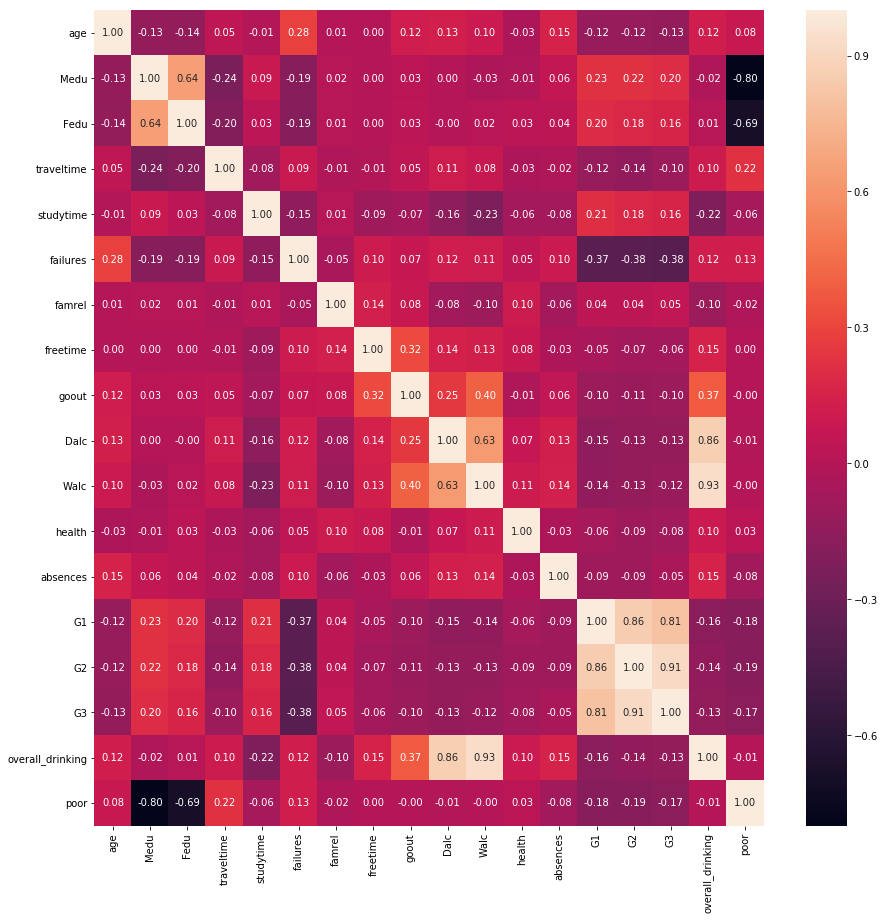

In [42]:
plt.figure(figsize=(15,15))
sns.heatmap(combined_data.corr(),annot = True,fmt = ".2f")
plt.xticks(rotation=90)

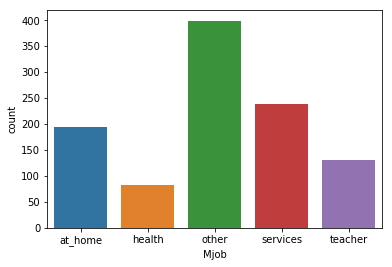

In [43]:
sns.countplot(x="Mjob", data=combined_data)

### Let's do some feature selection

1st we are going to impute some of our features to make them integers and then we will be able to use sklearn.

In [44]:
# Renaming to data to save time
data = combined_data

In [45]:
# Rename class column to reduce errors that occur
data['cls'] = data['class']
data = data.drop(['class'], axis=1)

In [46]:
data.dtypes

school              category
sex                 category
age                    int64
address             category
famsize             category
Pstatus             category
Medu                   int64
Fedu                   int64
Mjob                category
Fjob                category
reason              category
guardian            category
traveltime             int64
studytime              int64
failures               int64
schoolsup           category
famsup              category
paid                category
activities          category
nursery             category
higher              category
internet            category
romantic            category
famrel                 int64
freetime               int64
goout                  int64
Dalc                   int64
Walc                   int64
health                 int64
absences               int64
G1                     int64
G2                     int64
G3                     int64
overall_drinking     float64
poor          

In [47]:
# Use sklearn's LabelEncoder to transform the outcome to
school = preprocessing.LabelEncoder()
sex = preprocessing.LabelEncoder()
address = preprocessing.LabelEncoder()
famsize = preprocessing.LabelEncoder()
Pstatus = preprocessing.LabelEncoder()
Mjob = preprocessing.LabelEncoder()
Fjob = preprocessing.LabelEncoder()
reason = preprocessing.LabelEncoder()
guardian = preprocessing.LabelEncoder()
schoolsup = preprocessing.LabelEncoder()
famsup = preprocessing.LabelEncoder()
paid = preprocessing.LabelEncoder()
activities = preprocessing.LabelEncoder()
nursery = preprocessing.LabelEncoder()
higher = preprocessing.LabelEncoder()
internet = preprocessing.LabelEncoder()
romantic = preprocessing.LabelEncoder()
class_encoder = preprocessing.LabelEncoder()
drinking = preprocessing.LabelEncoder()

# Establish the relationship between categorical labels and integers
school.fit(data.school)
sex.fit(data.sex)
address.fit(data.address)
famsize.fit(data.famsize)
Pstatus.fit(data.Pstatus)
Mjob.fit(data.Mjob)
Fjob.fit(data.Fjob)
reason.fit(data.reason)
guardian.fit(data.guardian)
schoolsup.fit(data.schoolsup)
famsup.fit(data.famsup)
paid.fit(data.paid)
activities.fit(data.activities)
nursery.fit(data.nursery)
higher.fit(data.higher)
internet.fit(data.internet)
romantic.fit(data.romantic)
class_encoder.fit(data.cls)
drinking.fit(data.overall_drinking)

# Create your integer outcome by transforming the categorical column
data['school'] = school.transform(data.school)
data['sex'] = sex.transform(data.sex)
data['address'] = address.transform(data.address)
data['famsize'] = famsize.transform(data.famsize)
data['Pstatus'] = Pstatus.transform(data.Pstatus)
data['Mjob'] = Mjob.transform(data.Mjob)
data['Fjob'] = Fjob.transform(data.Fjob)
data['reason'] = reason.transform(data.reason)
data['guardian'] = guardian.transform(data.guardian)
data['schoolsup'] = schoolsup.transform(data.schoolsup)
data['famsup'] = famsup.transform(data.famsup)
data['paid'] = paid.transform(data.paid)
data['activities'] = activities.transform(data.activities)
data['nursery'] = nursery.transform(data.nursery)
data['higher'] = higher.transform(data.higher)
data['internet'] = internet.transform(data.internet)
data['romantic'] = romantic.transform(data.romantic)
data['cls'] = class_encoder.transform(data.cls)
data['overall_drinking'] = drinking.transform(data.overall_drinking)

In [48]:
data.dtypes
data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Dalc,Walc,health,absences,G1,G2,G3,overall_drinking,poor,cls
0,0,0,18,1,0,0,4,4,0,4,...,1,1,3,6,5,6,6,0,0,0
1,0,0,17,1,0,1,1,1,0,2,...,1,1,3,4,5,5,6,0,1,0
2,0,0,15,1,1,1,1,1,0,2,...,2,3,3,10,7,8,10,3,1,0
3,0,0,15,1,0,1,4,2,1,3,...,1,1,5,2,15,14,15,0,0,0
4,0,0,16,1,0,1,3,3,2,2,...,1,2,5,4,6,10,10,1,0,0
5,0,1,16,1,1,1,4,3,3,2,...,1,2,5,10,15,15,15,1,0,0
6,0,1,16,1,1,1,2,2,2,2,...,1,1,3,0,12,12,11,0,1,0
7,0,0,17,1,0,0,4,4,2,4,...,1,1,1,6,6,5,6,0,0,0
8,0,1,15,1,1,0,3,2,3,2,...,1,1,1,0,16,18,19,0,0,0
9,0,1,15,1,0,1,3,4,2,2,...,1,1,5,0,14,15,15,0,0,0


In [49]:
# An algorithmic approach to feature selection
# Source : https://planspace.org/20150423-forward_selection_with_statsmodels/
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [50]:
# For now dropping this because we couldn't get it to work otherwise
# But need to create a new overall drinking variable, probably not as a float
data = data.drop(['overall_drinking'], axis=1)

In [51]:
model = forward_selected(data, 'Walc')

In [52]:
print (model.model.formula)
print (model.rsquared_adj)

Walc ~ Dalc + goout + sex + studytime + famrel + health + freetime + absences + schoolsup + Medu + poor + paid + guardian + reason + famsize + nursery + Pstatus + famsup + romantic + school + address + 1
0.5099640270479748


### Now we can get a more complete idea of the correlation between G1 and our other features

Now we can decide exactly which features we want to carry over to our model

In [95]:
# Copy features from above into features we will use array and use this for a pipeline model
features_we_will_use = ['goout', 'sex', 'studytime', 'famrel', 'health', 'freetime', 'absences', 'schoolsup', 'Medu', 'poor', 'paid', 'guardian', 'reason', 'famsize', 'nursery', 'Pstatus', 'famsup', 'romantic', 'school', 'address']
small_data = data[features_we_will_use]

### Pipeline Modeling

In [110]:
train_features, test_features, train_outcome, test_outcome = train_test_split(
    small_data,
    data.Walc,
    test_size=0.30
)

In [116]:
#pipe = make_pipeline(PolynomialFeatures(), MinMaxScaler(), KNeighborsRegressor())

# Define a grid to search through (including the degree of polynomial)
#param_grid = {'polynomialfeatures__degree':range(1, 4),
               # 'kneighborsregressor__n_neighbors':range(1, 10),
               # 'kneighborsregressor__weights':["uniform", "distance"]}


# Perform a grid search of your pipeline


pipe = make_pipeline(Imputer(), MinMaxScaler(), KNeighborsClassifier())

# Define a grid to search through
param_grid = {'kneighborsclassifier__n_neighbors':range(1, 20)}
# Define a grid to search through (including the degree of polynomial)
#param_grid = {'kneighborsclassifier__n_neighbors':range(1, 20)}
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error") # you may want to specify more parameters!

In [117]:
grid.fit(train_features, train_outcome)
grid.score(test_features, test_outcome)

-0.7420382165605095

In [121]:
grid.cv_results_['params'][grid.best_index_]

{'kneighborsclassifier__n_neighbors': 1}

In [136]:
knn_test_predict = grid.predict(test_features)
# Format for submission
knn_test_predict = [int(round(value)) for value in polynomial_test_predict]

In [137]:
accuracy_score(knn_test_predict, test_outcome, normalize=True)

0.5764331210191083

In [138]:
pipe2 = make_pipeline(Imputer(), MinMaxScaler(), XGBClassifier())

In [139]:
param_grid2 = {}
grid2 = GridSearchCV(pipe2, param_grid2, scoring="neg_mean_absolute_error") # you may want to specify more parameters!


In [140]:
grid2.fit(train_features, train_outcome)
grid2.score(test_features, test_outcome)
xgb_test_predict = grid2.predict(test_features)

/Users/emilytao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/emilytao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/emilytao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/emilytao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

In [141]:
accuracy_score(xgb_test_predict, test_outcome, normalize=True)

0.4840764331210191